In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from gpt.utils import file_to_string

In [2]:
def load_curriculum_training_log(logger_path):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)

    reward_dict = training_log["results_dict"]
    success = training_log["successes"].mean(axis=1)

    averaged_dicts = []

    for row in reward_dict:
        sum_dict = {}
        for col in row:
            for key in col:
                sum_dict[key] = sum_dict.get(key, 0) + col[key]

        avg_dict = {key: value/len(row) for key, value in sum_dict.items()}
        averaged_dicts.append(avg_dict)

    reward_df = pd.DataFrame(averaged_dicts)

    return reward_df, success

In [3]:
def load_training_log(logger_path):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)
    
    try:
        reward_main = training_log["results"].mean(axis=1)
    except:
        reward_main = None
    try:
        success = training_log["successes"].mean(axis=1)
    except:
        success = None
    
    return reward_main, success

In [4]:
def extract_curriculum(logger_path):
    # extract curriculum and return list of dictionaries with task details
    curriculum_txt = file_to_string(logger_path + "curriculum.md")
    # Split the string into individual task sections
    task_sections = re.split(r'\n\n(?=Task)', curriculum_txt)

    # Function to extract details from each task section
    def extract_task_details(task_section):

        details = {}
        lines = task_section.split('\n')
        for line in lines:
            if line.startswith('Task'):
                details['Task'] = line.split(' ')[1]
            elif line.startswith('Name:'):
                details['Name'] = line.split(': ')[1]
            elif line.startswith('Description:'):
                details['Description'] = line.split(': ')[1]
            elif line.startswith('Reason:'):
                details['Reason'] = ': '.join(line.split(': ')[1:])
        return details

    # Extract details for all tasks
    curriculum_info = [extract_task_details(section) for section in task_sections]
    curriculum_length = len(curriculum_info)
    
    return curriculum_info, curriculum_length

In [5]:
def extract_best_agent(logger_path, curriculum_info, curriculum_length):
    task_list = []
    best_agent_list = []
    for idx in range(curriculum_length):
        curriculum_name = curriculum_info[idx]['Name']
        task_list.append(curriculum_name)
        try:
            decision = file_to_string(logger_path + curriculum_name + '.md')
            decision = decision.split('\n')[0]
            numbers = re.findall(r'\d+', decision)
        except:
            numbers = [0]
        if numbers:
            best_agent_list.append(int(numbers[0]))
        else:
            print(f"No number found in the decision {idx}")
            best_agent_list.append(0)
            
    return task_list, best_agent_list

In [6]:
def summarize_results(logger_path, curriculum_exp_num, her_exp_num, sac_exp_num, scratch_exp_num):
    window_size = 10
    # Load the training logs for curriculum experiment
    curriculum_success_list = []
    for i in range(curriculum_exp_num):
        print("Loading curriculum experiment: ", i)
        curriculum_logger_path = logger_path + "curriculum_" + str(i) + "/"
        # if i == 3 or i == 4:
        #     print("Warning: This is using previous results")
        #     curriculum_logger_path = logger_path + "curriculum_" + str(i) + "_previous/" 
        curriculum_info, curriculum_length = extract_curriculum(curriculum_logger_path)
        task_list, best_sample_idx = extract_best_agent(curriculum_logger_path, curriculum_info, curriculum_length)

        reward_main_list, reward_task_list, success_list, task_length_list = [], [], [], []
        for idx, task in enumerate(task_list):
            path = curriculum_logger_path + task + f"/sample_{best_sample_idx[idx]}"
            
            reward_df, success = load_curriculum_training_log(path)

            # print("Reward arguments in Task: ", task)
            # for key in reward_df.keys():
            #     print(key)

            reward_main_list.append(reward_df["main"])
            reward_task_list.append(reward_df["task"])
            success_list.append(success)
            task_length_list.append(len(reward_df["main"]))

        reward_main = np.concatenate(reward_main_list, axis=0)
        reward_task = np.concatenate(reward_task_list, axis=0)
        success_list = np.concatenate(success_list, axis=0)

        # compute the moving average of success rate
        success_moving_avg = pd.Series(success_list).rolling(window_size).mean().values
        curriculum_success_list.append(success_moving_avg)

    # Load the training logs for HER experiment
    her_success_list = []
    for i in range(her_exp_num):
        print("Loading HER experiment: ", i)
        her_logger_path = logger_path + "her_" + str(i) + "/"
        reward_main, success = load_training_log(her_logger_path)
        
        # compute the moving average of success rate
        success_moving_avg = pd.Series(success).rolling(window_size).mean().values
        her_success_list.append(success_moving_avg)

    # Load the training logs for SAC experiment
    sac_success_list = []
    for i in range(sac_exp_num):
        print("Loading SAC experiment: ", i)
        sac_logger_path = logger_path + "sac_" + str(i) + "/"
        reward_main, success = load_training_log(sac_logger_path)
        
        # compute the moving average of success rate
        success_moving_avg = pd.Series(success).rolling(window_size).mean().values
        sac_success_list.append(success_moving_avg)

    # Load the training logs for Scratch experiment
    scratch_success_list = []
    for i in range(scratch_exp_num):
        print("Loading Scratch experiment: ", i)
        scratch_logger_path = logger_path + "scratch_" + str(i) + "/"
        reward_main, success = load_training_log(scratch_logger_path)
        
        # compute the moving average of success rate
        success_moving_avg = pd.Series(success).rolling(window_size).mean().values
        scratch_success_list.append(success_moving_avg)

    return curriculum_success_list, her_success_list, sac_success_list, scratch_success_list


In [12]:
def plot_all(logger_path, curriculum_success_list, her_success_list, sac_success_list, scratch_success_list):
    plt.rcParams["font.family"] = 'serif'
    plt.rcParams["font.sans-serif"] = ['Palatino'] + plt.rcParams["font.sans-serif"]
    # Plot the success rate in same figure

    def extend_length(success_list):
        if not success_list:
            return np.array([])
        b = np.zeros([len(success_list),len(max(success_list,key = lambda x: len(x)))])
        for i,j in enumerate(success_list):
            b[i][0:len(j)] = j
            b[i][len(j):] = j[-1] # np.nan

        return b
    curriculum_success_list = extend_length(curriculum_success_list) # np.array(curriculum_success_list)
    her_success_list = extend_length(her_success_list)
    sac_success_list = extend_length(sac_success_list)
    scratch_success_list = extend_length(scratch_success_list)

    curriculum_success_avg = np.nanmean(curriculum_success_list, axis=0)
    her_success_avg = np.nanmean(her_success_list, axis=0)
    sac_success_avg = np.nanmean(sac_success_list, axis=0)
    scratch_success_avg = np.nanmean(scratch_success_list, axis=0)

    curriculum_success_std = np.nanstd(curriculum_success_list, axis=0)
    her_success_std = np.nanstd(her_success_list, axis=0)
    sac_success_std = np.nanstd(sac_success_list, axis=0)
    scratch_success_std = np.nanstd(scratch_success_list, axis=0)

    # Find the shortest length
    min_length = min(len(curriculum_success_avg), len(her_success_avg), len(sac_success_avg), len(scratch_success_avg))
    curriculum_success_avg = curriculum_success_avg[:min_length]
    her_success_avg = her_success_avg[:min_length]
    sac_success_avg = sac_success_avg[:min_length]
    scratch_success_avg = scratch_success_avg[:min_length]
    curriculum_success_std = curriculum_success_std[:min_length]
    her_success_std = her_success_std[:min_length]
    sac_success_std = sac_success_std[:min_length]
    scratch_success_std = scratch_success_std[:min_length]

    # Assign color to each experiments
    curriculum_color = 'orange'
    her_color = 'forestgreen'
    sac_color = 'deepskyblue'
    scratch_color = 'orangered' #'royalblue', 'orangered'

    # Plot the success rate
    plt.figure()
    plt.plot(curriculum_success_avg, label='CurricuLLM (Ours)', color=curriculum_color)
    plt.fill_between(np.arange(len(curriculum_success_avg)), curriculum_success_avg - curriculum_success_std, curriculum_success_avg + curriculum_success_std, color=curriculum_color, alpha=0.2)
    if her_success_list.size != 0:
        plt.plot(her_success_avg, label='HER', color=her_color)
        plt.fill_between(np.arange(len(her_success_avg)), her_success_avg - her_success_std, her_success_avg + her_success_std, color=her_color, alpha=0.2)
    if sac_success_list.size != 0:
        plt.plot(sac_success_avg, label='SAC', color=sac_color)
        plt.fill_between(np.arange(len(sac_success_avg)), sac_success_avg - sac_success_std, sac_success_avg + sac_success_std, color=sac_color, alpha=0.2)
    if scratch_success_list.size != 0:
        plt.plot(scratch_success_avg, label='LLM-zeroshot', color=scratch_color)
        plt.fill_between(np.arange(len(scratch_success_avg)), scratch_success_avg - scratch_success_std, scratch_success_avg + scratch_success_std, color=scratch_color, alpha=0.2)
    plt.xlabel('Episodes (x1000)', fontsize=14)
    plt.ylabel('Success Rate', fontsize=14)
    plt.legend(frameon=False, fontsize=14)
    plt.title('Success Rate', fontsize=16)
    
    # Remove the top and right axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Save the figure to logger path
    plt.savefig(logger_path + "success_rate.pdf")

Loading curriculum experiment:  0
Loading curriculum experiment:  1
Loading curriculum experiment:  2
Loading curriculum experiment:  3
Loading HER experiment:  0
Loading HER experiment:  1
Loading HER experiment:  2
Loading HER experiment:  3
Loading SAC experiment:  0
Loading SAC experiment:  1
Loading SAC experiment:  2
Loading Scratch experiment:  0
Loading Scratch experiment:  1
Loading Scratch experiment:  2
Loading Scratch experiment:  3
Loading Scratch experiment:  4
Loading Scratch experiment:  5
Loading Scratch experiment:  6


/tmp/ipykernel_316893/448929045.py:22: RuntimeWarning: Mean of empty slice
  curriculum_success_avg = np.nanmean(curriculum_success_list, axis=0)
/tmp/ipykernel_316893/448929045.py:23: RuntimeWarning: Mean of empty slice
  her_success_avg = np.nanmean(her_success_list, axis=0)
/tmp/ipykernel_316893/448929045.py:24: RuntimeWarning: Mean of empty slice
  sac_success_avg = np.nanmean(sac_success_list, axis=0)
/tmp/ipykernel_316893/448929045.py:25: RuntimeWarning: Mean of empty slice
  scratch_success_avg = np.nanmean(scratch_success_list, axis=0)


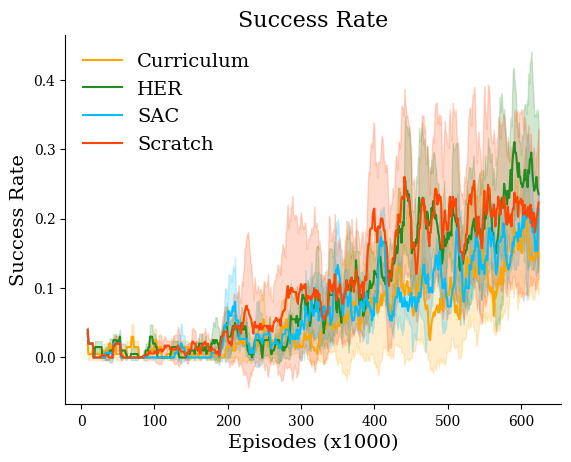

In [18]:
logger_path = "logs/Fetch_Slide/"
curriculum_exp_num = 1
her_exp_num = 1
sac_exp_num = 1
scratch_exp_num = 1

curriculum_success_list, her_success_list, sac_success_list, scratch_success_list = summarize_results(logger_path, curriculum_exp_num, her_exp_num, sac_exp_num, scratch_exp_num)
plot_all(logger_path, curriculum_success_list, her_success_list, sac_success_list, scratch_success_list)